# End-to-end Continuous Sign Language Recognition with Visual Alignment Constraint

## Introduction

Sign language is commonly known as the primary means of communication in deaf and hard of hearing community. Different from natural languages, sign language has its own vocabulary and grammar [1], and the contents are conveyed mainly by manual gestures/movements and facial expressions [2, 3]. Considering its potential contribution to facilitate communication between deaf and hearing people and its divergence from ordinary natural languages, sign language recognition and translation are regarded as of high practical and research values.

Unlike sign language translation (SLT) task, which translates sign language input to natural languages, sign language recognition (SLR) task aims to detect signs from sign language inputs and translate them into sign language vocabulary (also known as “gloss”). In particular, continuous sign language recognition (CSLR) systems takes a sign language sequence as input (usually in the form of a video/image stream) and outputs a gloss sequence. 

A major challenge in continuous sign language recognition task is that it is costly or even impossible to collect fully annotated data [4], thus many previous works attempt to solve the problem in a weakly supervised setting. Some of them adopt a deep neural network which consists of two modules. A feature extractor converts flows of images to a sequence of feature vectors, then an alignment module learns the long-term frequency in the feature sequence and align each part of it to the gold label accordingly. By introducing connectionist temporal classification (CTC) loss, the model can be trained by maximizing the probability of the gold gloss sequences [5].

Although CTC-based methods allow us to train a CSLR model without leveraging frame-level annotations, in practice it suffers from overfitting problem, as the amount of training data is limited. Previous work proposed a reasonable explanation that the alignment module tends to overfit the training data and converges faster [6]. As a result, the feature extractor is not fully exploited and this leads to longer training time and poor performance. In this paper, we’ll experiment with some methods that aim to fix this problem and compare them to the vanilla CTC-based recurrent convolutional model in terms of performance and efficiency.


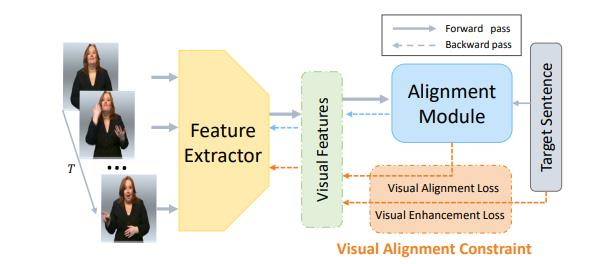

In [1]:
from IPython.display import Image 
Image(filename='model_description.jpg')

## Related Work

The development of deep learning makes it possible for continuous sign language recognition systems to automatically extract features from videos and build alignments between features and gold labels. Some recent methods use convolutional neural network to extract spatial and short-term temporal features, and use RNN-based models/attention mechanism for alignment. They then adopt CTC loss to map alignments to outputs to avoid using frame-level supervision. 

Though such models have brought considerable improvement to CSLR performance, many researchers found out that end-to-end training with such models is prone to overfitting [6]. To adapt the training to the fact that only limited data is available in sign language researches, some researchers adopt iterative training [7]. Cui et al. [8] use alignment proposal from the end-to-end trained model as an intermediate pseudo supervision to train the feature extractor, then use the optimized feature extractor to fine-tune the whole model. Min et al. [6] proposed Visual Alignment Constraint (VAC) to enhance the feature extractor with alignment supervision. This method leverages two additional losses and makes the model end-to-end trainable. The architecture of a VAC is shown above. The current state-of-the-art method makes use of Self-Mutual Knowledge Distillation (SMKD) [9], forcing the visual and alignment module to share the same classifier weight matrix. In this way, they reach a word error rate (WER) of 20.8/21.0 on the development/test set of PHOENIX-2014 dataset [10].

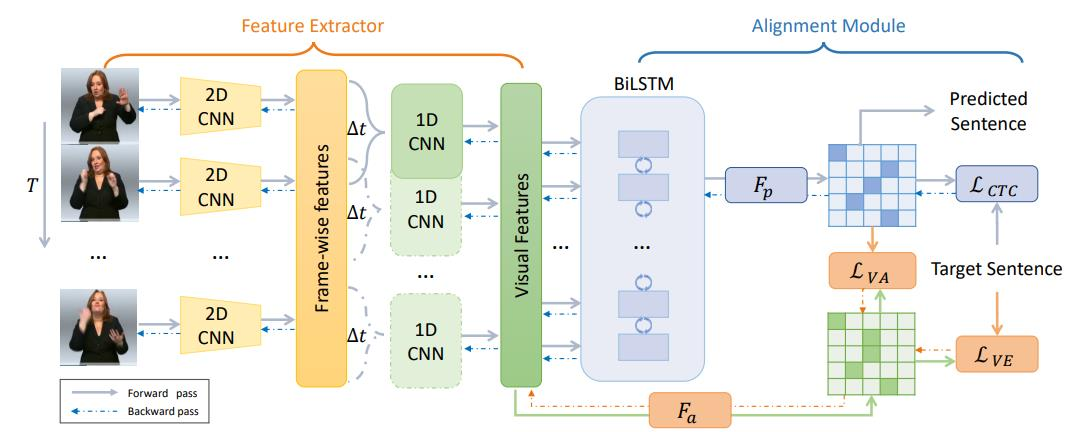

In [2]:
from IPython.display import Image 
Image(filename='model_architecture.jpg')

## Method

In this term paper, we revisit Visual Alignment Constraint and analyse how this method benefits training compared to a vanilla end-to-end training process. By introducing addition Visual Enhancement (VE) loss and Visual Alignment (VA) loss, the overfitting problem can be effectively countered and it should lead to better model performance and higher training efficiency.

### Model Formulation

As the figure above shows, the feature extractor adopted here is a 2D-CNN followed by a temporal fusion model, which is a 1D-CNN with receptive field $l$ and stride $\Delta t$. The feature extractor module is supposed to first extract features from each frame and then fuse information from adjacent frames. A Bi-LSTM sequence learning module captures long-range dependency and contextualize the visual features. Following that, a softmax classifier assigns probability to all possible alignments and a CTC loss function builds a many-to-one mapping between alignments and outputs. In this way, the probability of an output can be calculated as the sum of all possible alignments that correspond to it. The model is trained to maximize the probability of the ground truth on the training set. $F_p$ and $F_a$ are logits from the primary and auxiliary classifiers respectively.

### Auxiliary Losses

In addition to the original CTC loss, two auxiliary losses are introduced to solve overfitting problem. They are referred to as VE and VA losses in the model.

VE loss: One explanation for the difficulty of end-to-end training in continuous sign language recognition is that the gradient has to flow through the sequence learning module before it comes to the feature extractor. As the data amount is limited, the sequence learning module tends to converge fast [6], so that the chain rule makes the gradient of feature extractor very small. We build a direct path from feature extractor to the objective function by letting the output of the feature extractor to also make predictions. These predictions don’t rely on alignment module and is based only on local features. The CTC loss between its prediction and the gold label is named Visual Enhancement loss. 

$$ 
\mathcal{L}_{VE} = 
\mathcal{L}^v_{CTC} = 
-\log{p(\mathbb{l}|\boldsymbol{X}; \theta^v)}
$$

VA loss: The two classifiers (primary classifier from the sequence learning module and auxiliary classifier from the feature extraction model) make predictions based on different information: the features for auxiliary classifier are local, while the features for primary classifier are contextualized. However, we hope that the feature extractor can extract features that can be used for both classifiers, rather than it fits only one classifier and ignores the other one. Out of this intuition, we punish the model when the predictions from two classifiers are too different. The Visual Alignment loss is formulated as KL divergence between two sets of logits from these classifiers. It can also be seen as a knowledge distillation system, where the primary provides the feature extractor with long-term dependency information. A temperature parameter $\tau$ is used to prevent the softmax function from saturation.

$$ 
\mathcal{L}_{VA} = 
KL(softmax(\frac{F_p}{\tau}),  softmax(\frac{F_a}{\tau}))
$$

The final loss is calculated as the sum of the primary CTC loss, the Visual Enhancement loss and the Visual Alignment loss. 

$$
\mathcal{L} = 
\mathcal{L}_{CTC} + \mathcal{L}_{VE} + \alpha\mathcal{L}_{VA} 

$$


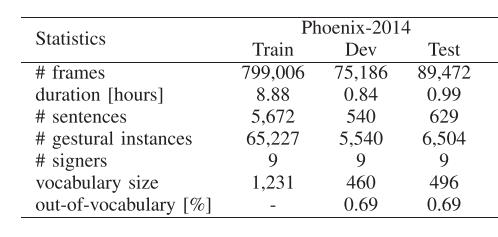

In [3]:
from IPython.display import Image 
Image(filename='dataset.jpg')

## Experiments

### Dataset and Experimental Protocol

The experiment is conducted on RWTH-PHOENIX-Weather multi-signer 2014 database (see Fig. above). It contains 5,672, 540, 629 weather forecast videos performed by 9 signers for training, development and test set respectively. The vocabulary size is 1295 (excluding “\<BLANK>” token). We follow the split of the original dataset, training the model on training set and tuning parameters on the development set and evaluating on the test set. In this experiment, we only use the full frame features (210x260) and they are resized to 224x224 for convenience. During training, the video inputs are augmented by introducing random height/width jitter and temporal rescaling (±20%). On the development and test set we apply no data augmentation. Each image is normalized following the recommendation from the pre-trained CNN model.

For the feature extractor module, we use pre-trained ResNet-18 [11] to project each input frame to a 1024-dimensional feature vector. Then a stack of 1D temporal convolution and pooling with receptive field $l=16$ and stride $\Delta t=4$ generates spatio-temporal features. The selection of $l$ and $\Delta t$ is discussed in more detail in Cui et al.’s work [7], and we follow the best-performing model hyperparameters on the PHOENIX-2014 dataset from the paper. 

A two-layer Bi-LSTM with 2x512 dimensional hidden states is used to learn long-term dependency from the sequence. The output is fed into a softmax classifier and projected to the vocabulary size (1296 in this case).

With a mini-batch size of 2, training is conducted with an Adam optimizer with initial learning rate of 0.0001 and weight decay rate 0.0001. The learning rate is divided by 5 after 40 and 60 epochs. We train all models for 80 epochs on the training set, and early stop the training based on dev WER with patience equal to 10. A full run of 80 epochs takes approximately 200 hours on a V100 GPU.

In addition to the baseline model described above, our VAC model leverage auxiliary VE and VA losses. In particular, we only train and evaluate two models, one with additional VE loss and one with both VE and VA losses (referred to as VE model and VAC model below). For the VA loss, the temperature $\tau$ is set to 8 and the weight $\alpha$ is 25. 

The performance of the models is evaluated by Word Error Rate (WER). It measures the edit distance between the model output and the gold label sequence. More precisely, it is defined as:

$$
WER = 
\frac{\# sub + \# ins + \# del}{\# reference}
$$

Here $\#sub$, $\#del$ and $\#ins$ are the number of substitution, deletion and insertion operations, and $\#reference$ is the number of labels in the ground truth sequence.

### Results and Analyses

#### 1. Model Performance

Within the limited time, only one model is trained for each setting, and the results are given below in the table. For the performance, the baseline model with not auxiliary losses reaches a word error rate of 42.4 and 42.1 percent on dev and test set. After introducing VE loss, the WER decreased significantly by around 10%. Adding VA loss further improves the performance by about 3%. However, we also observe that the dev WER of VE model and VAC model shows no big difference before the 40th epoch, but VE model stops early and VAC model keeps training and gains more improvement after epoch 40 when the learning rate is turned smaller. Based on that we remain skeptical whether this 3% gap can truly reflect the model performance difference. An average of several runs should be a more objective measure of the performance. In the original paper, the VAC model has a WER of 21.2/22.3 percent on dev and test set. The reasons for the better performance will be discussed in the following section.


||WER on Dev|WER on Test|
|-|-|-|
|Baseline|42.4|42.1|
|Baseline+VE|31.9|31.0|
|Baseline+VE+VA|28.3|28.9|
|Baseline+VE+VA from paper[6]|21.2|22.3|





In [4]:
# VAC model performance on test set
from model_evaluate import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("VAC model WER:")
model_evaluate('data/vac_model/vac_model.pt', 'test', device)

VAC model WER:


Using cache found in /home/CE/yifwang/.cache/torch/hub/pytorch_vision_v0.10.0


Apply test transform
0.28905534744262695


In [5]:
# VE model performance on test set
print("VE model WER:")
model_evaluate('data/ve_model/ve_model.pt', 'test', device)

VE model WER:


Using cache found in /home/CE/yifwang/.cache/torch/hub/pytorch_vision_v0.10.0


Apply test transform
0.3095383644104004


In [6]:
# Baseline model performance on test set
print("Baseline model WER:")
model_evaluate('data/ctc_model/ctc_model.pt', 'test', device)

Baseline model WER:


Using cache found in /home/CE/yifwang/.cache/torch/hub/pytorch_vision_v0.10.0


Apply test transform
0.4212779104709625


#### 2. Training Efficiency

The statistics of the training process of three models is listed below. For training efficiency, VE model stops the first. It reaches the lowest dev WER at epoch 17 and does not improve in the patience period after that. Baseline model and VAC model stop at about the 50th/60th epoch. Especially, it takes only 3 to 4 epochs for the VE and VAC model to achieve the best performance of baseline model, which is observed after 40 epochs. We can thus conclude that with additional VE loss, the model learns much faster than the baseline model. But adding VA loss doesn't accelerate training further. 

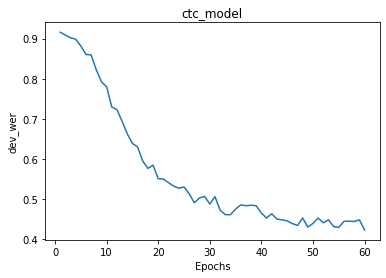

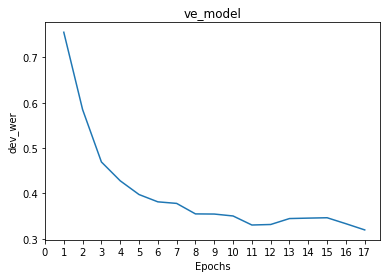

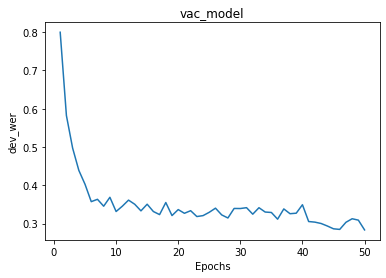

In [7]:
# statistics of vac/ve/baseline model training process
from plot_training_result import plot_training_stat
plot_training_stat('ctc', 'dev_wer')
plot_training_stat('ve', 'dev_wer')
plot_training_stat('vac', 'dev_wer')

#### 3. Reasons for performance gap with the paper

It can be noticed that there is a performance gap of about 6-7% between the VAC model and the paper implementation. This difference can be attributed to different implementation in the following aspects:


- Data augmentation

Compared to our implementation, where the input frames are resized directly to 224 $\times$ 224, the original paper first resizes images to 256 $\times$ 256 and a sub-image of 224 $\times$ 224 pixels is cropped randomly in the training and from the center during evaluation. This adds more noise to the training data and leads to better generalization. Besides, they also adapt random color deviation, random horizontal flip for data augmentation.

 
- Batch normalization

In the paper's implementation, they also add batch normalization layers in the temporal fusion module after each convolution layer. This should accelerate the training process and give better performance. Especially the learning rate decay steps (40 and 60) are paired with the original training scheme with different learning efficency, thus it is understandable that it may not lead to a full training of my models, because sometimes the model fulfils early stopping condition when it can be further improved using smaller learning rates.

- Initialization

In my implementation, the initialization of parameters is random. In the paper's experiment, they follow Xavier uniform initialization. A better initialization can be sometimes critical to model training and reduce randomness.


#### 4. Discussion

Despite the randomness induced by only one single run, some effects of additional losses can be observed from the experiments. Compared to the vanilla end-to-end training, introducing VE loss not only improve the model performance by a large margin (10% in the experiment), it also reduces the time amount needed for training. The possible reason is that the gradients can flow more easily through layers and guide training with a direct path between feature extractor and the loss function. Similar approaches like residual connection should have comparable effects, but it requires further experiments. The effect of VA loss is not as significant as VE loss in this experiment. It is supposed to prevent the two classifier from learning too different information, so that it doesn't overfit the training data. But this situation doesn't happen in the VE model training. Considering that the improvement from VA loss is also relatively marginal in the original paper (around 1.5%), the influence of adding VA loss should be further explored with more carefully designed experiments and ablation studies. Weight sharing in the authors' later work [9] plays a similar role to VA loss. 

## Conclusion

With better designed and implemented experiments, Min et al. [6] propose Visual Alignment Constraint (VAC) for continuous sign language recognition task and conclude that introducing auxiliary losses provides the feature extractor with more visual supervision, so that it can be better exploited in an end-to-end training setting. The visual enhancement loss forces the feature extractor to make predictions based on local information only and visual alignment loss teaches the feature extractor information from the whole model. This can to some extend solve the overfitting problem in CSLR. The improved performance confirms its superiority to previous iterative training methods. 

## References

[1] Wendy Sandler and Diane Lillo-Martin. Sign language and linguistic universals. Cambridge University Press, 2006. 1

[2] Philippe Dreuw, David Rybach, Thomas Deselaers, Morteza Zahedi, and Hermann Ney. Speech recognition techniques for a sign language recognition system. In Eighth Annual Conference of the International Speech Communication Association, 2007. 1

[3] Sylvie CW Ong and Surendra Ranganath. Automatic sign
language analysis: A survey and the future beyond lexical
meaning. IEEE Transactions on Pattern Analysis and Machine Intelligence, (6):873–891, 2005. 1, 2

[4] Danielle Bragg, Oscar Koller, Mary Bellard, Larwan Berke,
Patrick Boudreault, Annelies Braffort, Naomi Caselli, Matt
Huenerfauth, Hernisa Kacorri, Tessa Verhoef, et al. Sign
language recognition, generation, and translation: An interdisciplinary perspective. In The 21st International ACM
SIGACCESS Conference on Computers and Accessibility,
pages 16–31, 2019. 1

[5] Alex Graves, Santiago Fernandez, Faustino Gomez, and 
Jurgen Schmidhuber. Connectionist temporal classification: 
labelling unsegmented sequence data with recurrent neural
networks. In Proceedings of the 23rd International Conference on Machine learning, pages 369–376, 2006. 1, 2, 3

[6] Yuecong Min, Aiming Hao, Xiujuan Chai, and Xilin Chen.
Visual alignment constraint for continuous sign language
recognition. arXiv preprint arXiv:2104.02330, 2021. 2, 8

[7] Junfu Pu, Wengang Zhou, and Houqiang Li. Iterative alignment network for continuous sign language recognition. In
Proceedings of the IEEE Conference on Computer Vision
and Pattern Recognition, pages 4165–4174, 2019. 1, 2, 4,
8

[8] Runpeng Cui, Hu Liu, and Changshui Zhang. A deep
neural framework for continuous sign language recognition
by iterative training. IEEE Transactions on Multimedia,
21(7):1880–1891, 2019. 1, 2, 3, 4, 7, 8

[9] Hao, Aiming, Yuecong Min, and Xilin Chen. "Self-Mutual Distillation Learning for Continuous Sign Language Recognition." In Proceedings of the IEEE/CVF International Conference on Computer Vision, pp. 11303-11312. 2021.

[10] Oscar Koller, Jens Forster, and Hermann Ney. Continuous
sign language recognition: Towards large vocabulary statistical recognition systems handling multiple signers. Computer
Vision and Image Understanding, 141:108–125, 2015. 2, 5,
6

[11] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun.
Deep residual learning for image recognition. In Proceedings of the IEEE Conference on Computer Vision and Pattern
Recognition, pages 770–778, 2016. 2, 6
